In [ ]:
from nba_api.stats.endpoints import playbyplayv2, leaguegamefinder
from nba_api.stats.static import players
import pandas as pd

#used to avoid getting timed out
import time

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [21]:
#get the halibans player id
player_list = players.find_players_by_full_name("Tyrese Haliburton")
haliburton_id = player_list[0]['id']

In [34]:
#object that stores haliburtons game stats for the 2024-2025 season
gamefinder = leaguegamefinder.LeagueGameFinder(player_id_nullable=haliburton_id, season_nullable="2024-25")
#Calls the .get_data_frames() method on the gamefinder object
games = gamefinder.get_data_frames()[0]
#Extracts the GAME_ID column and uses unique in case theres duplicates
game_ids = games['GAME_ID'].unique()

#starts up the initial empty list, Were gonna fit dictionaries of data in here
game_points = []

#starts a for loop for unique game ids, meaning it will be one for each time the Halimonster played
for game_id in game_ids:
    # Avoid getting rate-limited
    time.sleep(1.2)
    #Calls the NBA API for the current game stats
    pbp = playbyplayv2.PlayByPlayV2(game_id=game_id)
    #Extracts the first DataFrame returned — the main stat one
    df = pbp.get_data_frames()[0]

    #filters the data to just the scoring plays by Haliburton returning a DF of his made shots
    scoring = df[
        (df['PLAYER1_ID'] == haliburton_id) &
        (df['EVENTMSGTYPE'].isin([1, 3]))  # 1 = FG Made, 3 = FT Made
    ]

    #function figures out how many points each play was worth, get numbers from NBA stat glossary
    def get_points(row):
        if row['EVENTMSGTYPE'] == 1:  # Field Goal
            return 3 if '3PT' in str(row['HOMEDESCRIPTION']) or '3PT' in str(row['VISITORDESCRIPTION']) else 2
        elif row['EVENTMSGTYPE'] == 3:  # Free Throw
            return 1
        return 0

    #applies the new function to every scoring row and creates a new column called points
    scoring['POINTS'] = scoring.apply(get_points, axis=1)
    #groups haliburtons points by quarter, sums them, reorders quarters to 1, 2, 3, and 4 and fills df with 0 if no points were made
    quarter_points = scoring.groupby('PERIOD')['POINTS'].sum().reindex([1, 2, 3, 4], fill_value=0)

    #filters for Haliburton assists — EVENTMSGTYPE 2 means assist
    assists = df[
        (df['PLAYER1_ID'] == haliburton_id) &
        (df['EVENTMSGTYPE'] == 2)
    ]
    #grouping Haliburton’s assists by quarter
    quarter_assists = assists.groupby('PERIOD')['EVENTMSGTYPE'].count().reindex([1, 2, 3, 4], fill_value=0)

    #filters for Haliburton turnovers — EVENTMSGTYPE 5 means turnover
    turnovers = df[
        (df['PLAYER1_ID'] == haliburton_id) &
        (df['EVENTMSGTYPE'] == 5)
    ]
    #just counts how many turnovers he had that game
    turnover_count = len(turnovers)

    #finds the row for the games df to check for Matchup names for later
    game_row = games[games['GAME_ID'] == game_id].iloc[0]

    #HOTSTREAK DETECTION SOFTWARE HOTSTREAK DETECTION SOFTWARE  HOTSTREAK DETECTION SOFTWARE  HOTSTREAK DETECTION SOFTWARE

    #Filters the data to only made field goals by any player
    fg_made = df[(df['EVENTMSGTYPE'] == 1)]

    #Checks if IND is the home or away team by looking at the description of one play
    if 'IND' in df['HOMEDESCRIPTION'].dropna().iloc[0]:
        team_side = 'HOMEDESCRIPTION'
    else:
        team_side = 'VISITORDESCRIPTION'

    #Filters only the Pacers made shots using either team description or team abbreviation
    fg_made = fg_made[
        fg_made[team_side].str.contains("Haliburton|", na=False) | 
        (fg_made['PLAYER1_TEAM_ABBREVIATION'] == 'IND')
    ]

    #Sorts by EVENTNUM so we’re working in the actual order of the plays
    fg_made = fg_made.sort_values('EVENTNUM')

    #initialize streak counters
    streak = 0            # tracks current streak
    max_streak = 0        # highest streak in the game
    streaks = []          # list of every 3+ streak Haliburton has

    #loops through each Pacers made shot and tracks if Haliburton is on fire
    for _, row in fg_made.iterrows():
        if row['PLAYER1_ID'] == haliburton_id:
            streak += 1
            if streak >= 3:
                streaks.append(streak)  # adds to hot streak list
            max_streak = max(max_streak, streak)  # updates the biggest streak
        else:
            streak = 0  # someone else scored, streak ends

    #creates a dictionary of game info and adds it to the big list we made at the start
    game_points.append({
        'Game ID': game_id,
        'Date': game_row['GAME_DATE'],
        'Matchup': game_row['MATCHUP'],
        'Q1': quarter_points[1],
        'Q2': quarter_points[2],
        'Q3': quarter_points[3],
        'Q4': quarter_points[4],
        'Total': quarter_points.sum(),
        'AST_Q1': quarter_assists[1],   # Haliburton assists per quarter
        'AST_Q2': quarter_assists[2],
        'AST_Q3': quarter_assists[3],
        'AST_Q4': quarter_assists[4],
        'Turnovers': turnover_count,    # total turnovers that game
        'Max Streak': max_streak,       # longest field goal streak in this game
        '3+ Streaks': len(streaks)      # how many times he got 3 or more makes in a row
    })


/var/folders/k6/zc2mwyh15sb703_r7s1tw4x80000gn/T/ipykernel_92373/339855154.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scoring['POINTS'] = scoring.apply(get_points, axis=1)
/var/folders/k6/zc2mwyh15sb703_r7s1tw4x80000gn/T/ipykernel_92373/339855154.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scoring['POINTS'] = scoring.apply(get_points, axis=1)
/var/folders/k6/zc2mwyh15sb703_r7s1tw4x80000gn/T/ipykernel_92373/339855154.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [35]:
df_final = pd.DataFrame(game_points)

In [36]:
df_final.head()

,Game ID,Date,Matchup,Q1,Q2,Q3,Q4,Total,AST_Q1,AST_Q2,AST_Q3,AST_Q4,Turnovers,Max Streak,3+ Streaks
0,0042400407,2025-06-22,IND @ OKC,9.0,0.0,0.0,0.0,9.0,2,0,0,0,1,3,1
1,0042400406,2025-06-19,IND vs. OKC,4.0,8.0,2.0,0.0,14.0,4,1,2,0,1,1,0
2,0042400405,2025-06-16,IND @ OKC,0.0,0.0,2.0,2.0,4.0,2,3,1,0,3,0,0
3,0042400404,2025-06-13,IND vs. OKC,3.0,5.0,2.0,8.0,18.0,2,1,1,4,5,1,0
4,0042400403,2025-06-11,IND vs. OKC,5.0,7.0,7.0,3.0,22.0,1,2,2,3,4,2,0


In [ ]:
#export as csv
df_final.to_csv("haliburton_quarter_stats.csv", index=False)
print("Saved to haliburton_quarter_stats.csv")

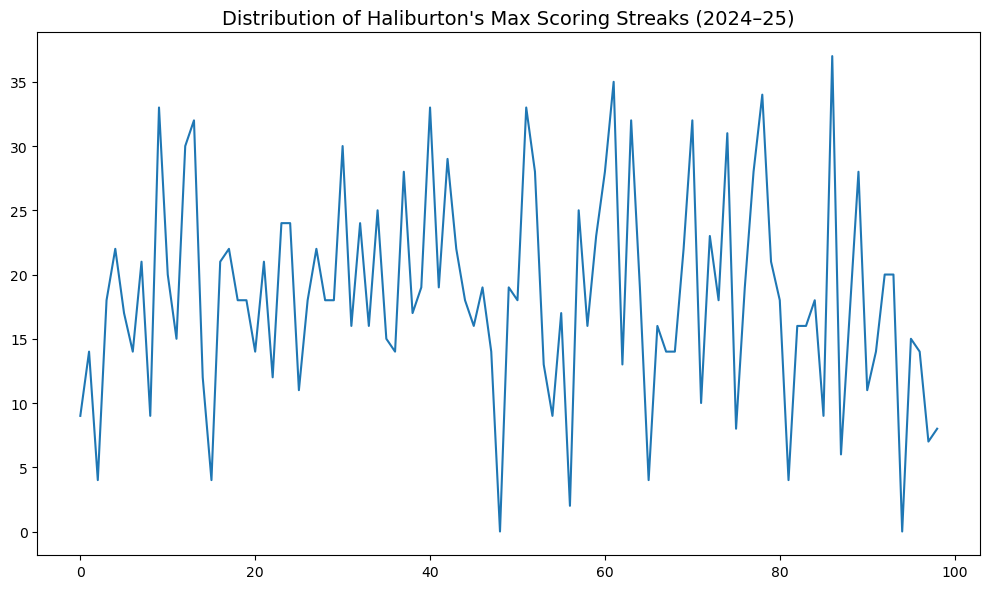

In [50]:
import matplotlib.pyplot as plt
streak_data = df_final['Total'].dropna()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.plot(streak_data)

# Add titles and labels
plt.title("Distribution of Haliburton's Max Scoring Streaks (2024–25)", fontsize=14)



# Show the plot
plt.tight_layout()
plt.show()

In [53]:
streak_data

0      9.0
1     14.0
2      4.0
3     18.0
4     22.0
      ... 
94     0.0
95    15.0
96    14.0
97     7.0
98     8.0
Name: Total, Length: 99, dtype: float64